In [1]:
#read in data
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import pymc as pm
import arviz as az
import os 

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [45]:
import numpy as np
import pandas as pd
import json

# Define servo indices (as you've already done)
servoIndices = {
    "NeckTilt": 0,
    "NeckPan": 1,
    "LeftEye": 2,
    "RightEye": 3,
    "LeftPupil": 4,
    "RightPupil": 5,
    "LeftArmJoint1": 6,
    "LeftArmJoint2": 7,
    "LeftArmJoint3": 8,
    "LeftArmJoint4": 9,
    "LeftArmJoint5": 10,
    "LeftHand": 11,
    "RightArmJoint1": 12,
    "RightArmJoint2": 13,
    "RightArmJoint3": 14,
    "RightArmJoint4": 15,
    "RightArmJoint5": 16,
    "RightHand": 17,
    "Body": 18
}

def parse_array(values):
    return np.array(values)

def read_data_json(file):
    # Initialize an empty DataFrame with required columns
    df = pd.DataFrame(columns=['UniqueID', 'Trajectory', 'Current', 'GyroX', 'GyroY', 'GyroZ', 'AccelX', 'AccelY', 'AccelZ'])
    
    with open(file) as f:
        data = json.load(f)
    
    # Extract data for each trajectory
    all_rows = []
    for traj in data['Trajectories']:
        unique_id = traj['UniqueID']
        trajectory = parse_array(traj['Trajectory'])
        current = parse_array(traj['Current'])
        gyro = parse_array(traj['Gyro'])
        accel = parse_array(traj['Accel'])
        
        # For each point in the trajectory, create a single row with individual values
        for i in range(len(trajectory)):
            row = {
                'UniqueID': unique_id,
                'Trajectory': trajectory[i],
                'Current': current[i],
                'GyroX': gyro[i, 0],
                'GyroY': gyro[i, 1],
                'GyroZ': gyro[i, 2],
                'AccelX': accel[i, 0],
                'AccelY': accel[i, 1],
                'AccelZ': accel[i, 2]
            }
            all_rows.append(row)
    
    # Create a DataFrame from the collected rows
    df = pd.DataFrame(all_rows)
    return df

# Example usage
df_2 = read_data_json("data/TrajectoriesTorsoConsistencyTest_Increment_2.json")
df_50 = read_data_json("data/TrajectoriesTorsoConsistencyTest_Increment_50.json")


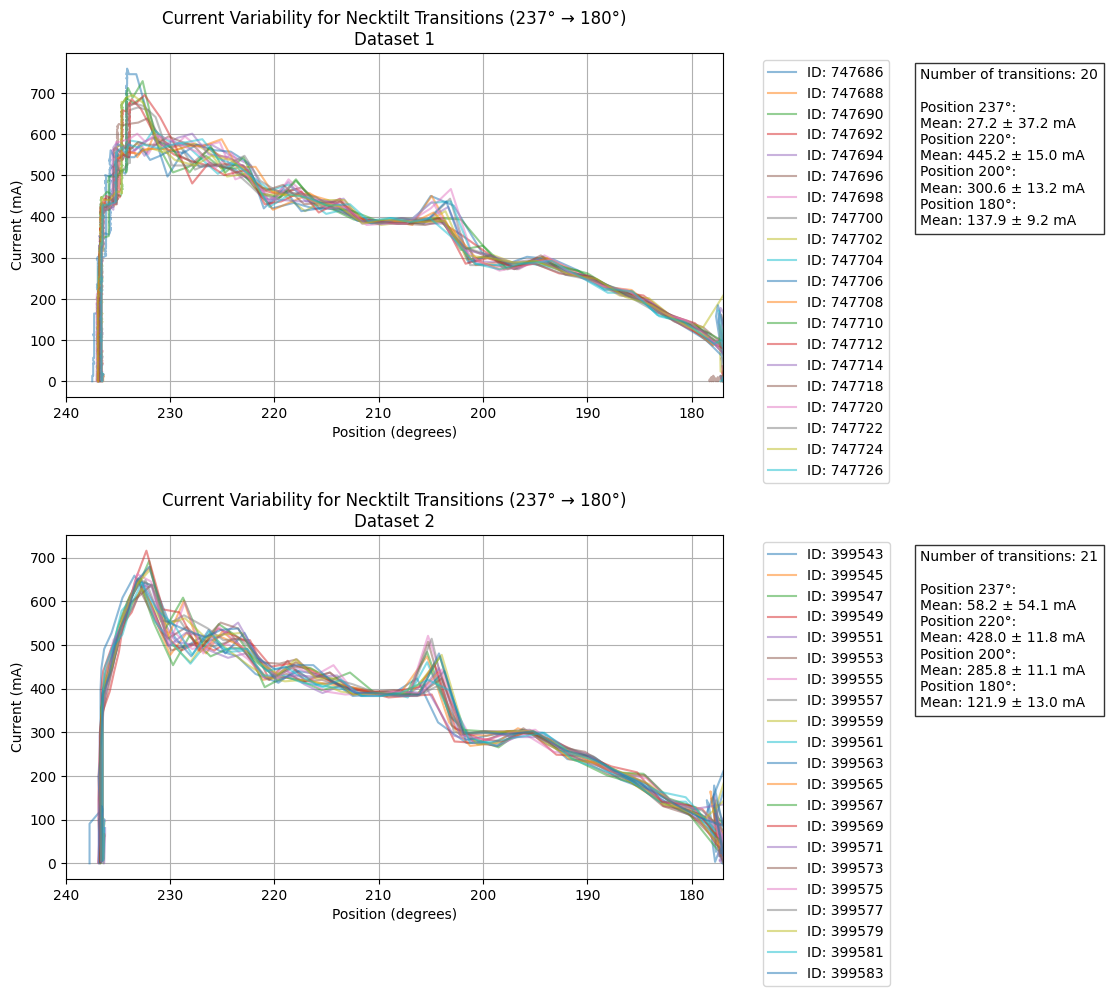

In [54]:
def plot_current_variability(dfs):
    # Create figure with subplots based on number of dataframes
    fig, axes = plt.subplots(len(dfs), 1, figsize=(12, 5*len(dfs)))
    if len(dfs) == 1:
        axes = [axes]  # Convert to list for consistent indexing
        
    for df_idx, df in enumerate(dfs):
        # Filter trajectories that go from ~237 to ~180 for Necktilt
        necktilt_transitions = []
        for unique_id in df['UniqueID'].unique():
            traj_data = df[df['UniqueID'] == unique_id]
            
            # Get first and last positions from trajectory
            start_pos = traj_data.iloc[0]['Trajectory'][0]  # First position
            end_pos = traj_data.iloc[-1]['Trajectory'][0]   # Last position
            
            # Check if trajectory goes from ~237 to ~180 (±3 degrees)
            if (234 <= start_pos <= 240) and (177 <= end_pos <= 183):
                necktilt_transitions.append(unique_id)

        # Plot current variability for this dataframe
        for transition_id in necktilt_transitions:
            transition_data = df[df['UniqueID'] == transition_id]
            current_values = [abs(curr[0]) for curr in transition_data['Current']]  # Get Necktilt current
            positions = [pos[0] for pos in transition_data['Trajectory']]      # Get Necktilt positions
            
            axes[df_idx].plot(positions, current_values, alpha=0.5, label=f'ID: {transition_id}')

        axes[df_idx].set_xlabel('Position (degrees)')
        axes[df_idx].set_ylabel('Current (mA)')
        axes[df_idx].set_title(f'Current Variability for Necktilt Transitions (237° → 180°)\nDataset {df_idx+1}')
        axes[df_idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[df_idx].set_xlim(240, 177)
        axes[df_idx].grid(True)

        # Add statistics as text annotation
        stats_text = f"Number of transitions: {len(necktilt_transitions)}\n"
        key_positions = [237, 220, 200, 180]
        for pos in key_positions:
            currents = []
            for tid in necktilt_transitions:
                tdata = df[df['UniqueID'] == tid]
                closest_idx = min(range(len(tdata)), key=lambda i: abs(tdata.iloc[i]['Trajectory'][0] - pos))
                currents.append(abs(tdata.iloc[closest_idx]['Current'][0]))
            
            stats_text += f"\nPosition {pos}°:\n"
            stats_text += f"Mean: {np.mean(currents):.1f} ± {np.std(currents):.1f} mA"
            
        axes[df_idx].text(1.3, 0.5, stats_text, transform=axes[df_idx].transAxes, 
                         bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

plot_current_variability([df_2, df_50])


Dataset 1 Movement Statistics:
Minimum current needed to move 5 degrees:
Mean: 306.17 ± 288.28 mA
Median: 547.68 mA
Min: 3.36 mA
Max: 641.76 mA

Dataset 2 Movement Statistics:
Minimum current needed to move 5 degrees:
Mean: 296.58 ± 254.20 mA
Median: 453.60 mA
Min: 3.36 mA
Max: 635.04 mA


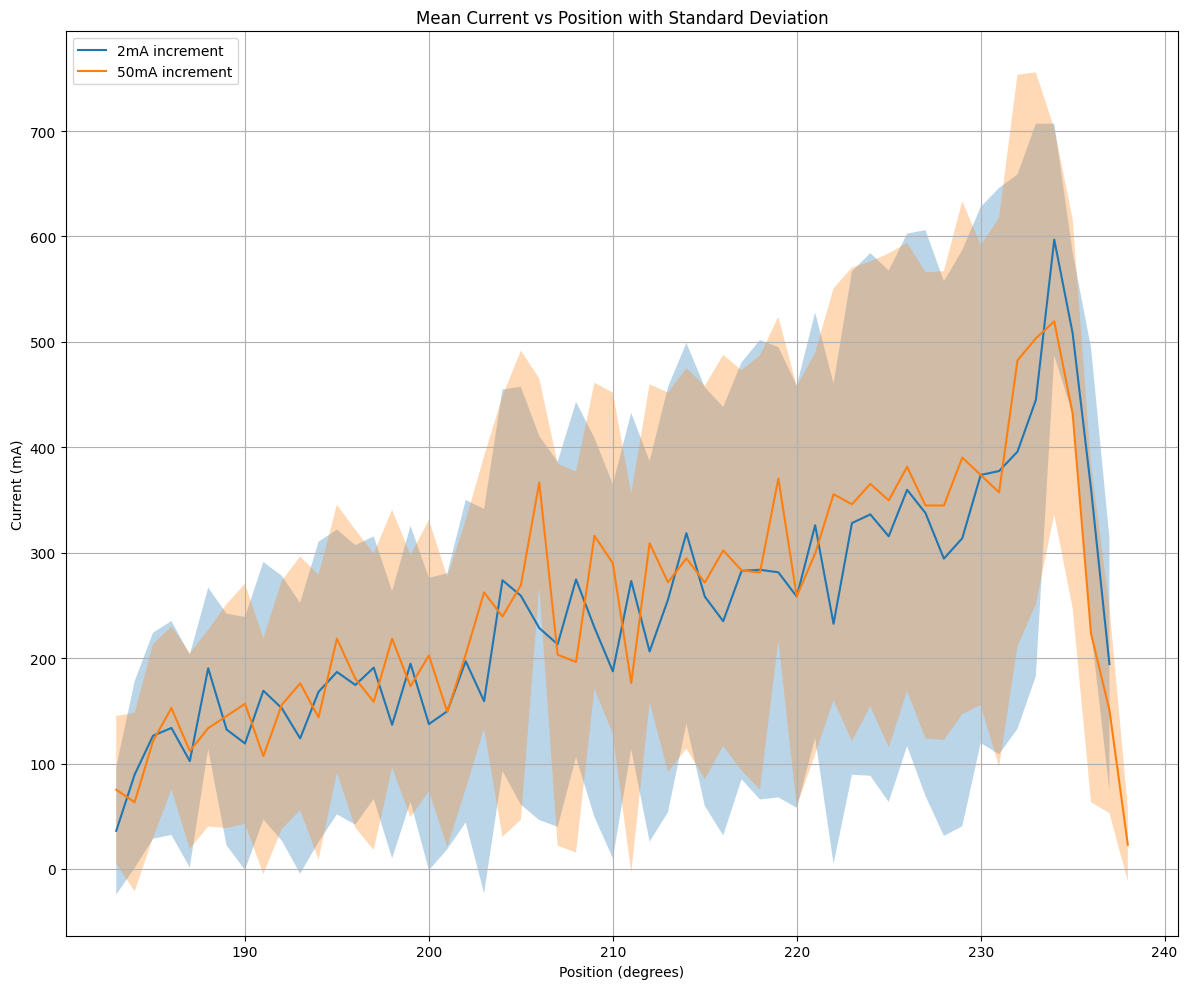

In [59]:
def plot_mean_currents_with_stats(dataframes, df_labels=None):
    """
    Plot mean currents with standard deviation for trajectories and calculate movement statistics.
    
    Args:
        dataframes: List of pandas dataframes containing trajectory data
    """
    plt.figure(figsize=(12, 10))
    
    for df_idx, df in enumerate(dataframes):
        # Initialize lists to store currents for each position
        positions = np.arange(240, 182, -1)  # Range from 240 to 183
        currents_by_position = {pos: [] for pos in positions}
        
        # Initialize list for minimum currents needed to move 5 degrees
        min_movement_currents = []
        
        # Process each trajectory
        for unique_id in df['UniqueID'].unique():
            traj_data = df[df['UniqueID'] == unique_id]
            
            # Get first and last positions
            start_pos = traj_data.iloc[0]['Trajectory'][0]
            end_pos = traj_data.iloc[-1]['Trajectory'][0]
            
            # Find minimum current needed to move 5 degrees
            for i in range(len(traj_data)):
                curr_pos = traj_data.iloc[i]['Trajectory'][0]
                if abs(curr_pos - end_pos) < abs(start_pos - end_pos) - 5:
                    min_movement_currents.append(abs(traj_data.iloc[i]['Current'][0]))
                    break
            
            # Collect currents for each position
            for i, row in traj_data.iterrows():
                pos = row['Trajectory'][0]
                # Find closest position bin
                closest_pos = min(positions, key=lambda x: abs(x - pos))
                currents_by_position[closest_pos].append(abs(row['Current'][0]))
        
        # Calculate means and standard deviations
        means = []
        stds = []
        valid_positions = []
        
        for pos in positions:
            if currents_by_position[pos]:  # Only include positions with data
                means.append(np.mean(currents_by_position[pos]))
                stds.append(np.std(currents_by_position[pos]))
                valid_positions.append(pos)
        
        # Plot mean current with std shadow
        plt.plot(valid_positions, means, label=f'{df_labels[df_idx]}')
        plt.fill_between(valid_positions, 
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        alpha=0.3)
        
        # Print movement statistics
        print(f"\nDataset {df_idx+1} Movement Statistics:")
        print(f"Minimum current needed to move 5 degrees:")
        print(f"Mean: {np.mean(min_movement_currents):.2f} ± {np.std(min_movement_currents):.2f} mA")
        print(f"Median: {np.median(min_movement_currents):.2f} mA")
        print(f"Min: {np.min(min_movement_currents):.2f} mA")
        print(f"Max: {np.max(min_movement_currents):.2f} mA")
        
    plt.xlabel('Position (degrees)')
    plt.ylabel('Current (mA)')
    plt.title('Mean Current vs Position with Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Test the function with the dataframes
plot_mean_currents_with_stats([df_2, df_50], ["2mA increment", "50mA increment"])



Minimum Current Statistics:
Mean: 306.17 mA
Median: 547.68 mA
Std Dev: 288.28 mA
Min: 3.36 mA
Max: 641.76 mA


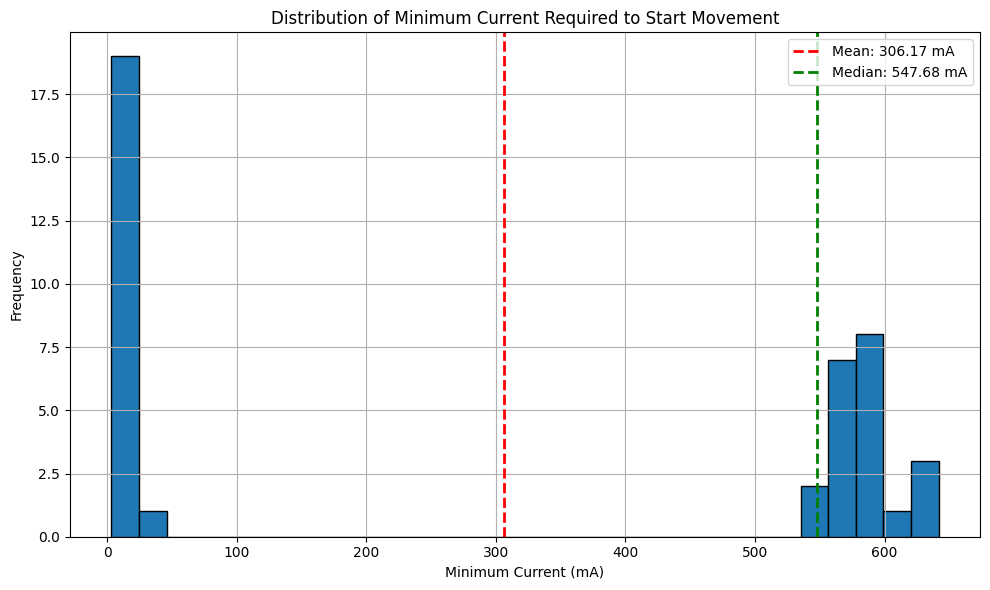

In [31]:
# Calculate minimum current needed to start movement for each trajectory
min_currents = []
for unique_id in df['UniqueID'].unique():
    trajectory_data = df[df['UniqueID'] == unique_id]
    
    # Get the current when position starts moving towards goal
    start_pos = trajectory_data.iloc[0]['Trajectory'][0]
    end_pos = trajectory_data.iloc[-1]['Trajectory'][0]
    for i in range(len(trajectory_data)):
        curr_pos = trajectory_data.iloc[i]['Trajectory'][0]
        # Check if position has moved more than 5 degrees closer to end position
        if abs(curr_pos - end_pos) < abs(start_pos - end_pos) - 5:
            min_currents.append(abs(trajectory_data.iloc[i]['Current'][0]))
            break

# Create histogram of minimum currents
plt.figure(figsize=(10, 6))
plt.hist(min_currents, bins=30, edgecolor='black')
plt.xlabel('Minimum Current (mA)')
plt.ylabel('Frequency')
plt.title('Distribution of Minimum Current Required to Start Movement')

# Add statistical annotations
plt.axvline(np.mean(min_currents), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(min_currents):.2f} mA')
plt.axvline(np.median(min_currents), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(min_currents):.2f} mA')

# Print statistics
print(f"\nMinimum Current Statistics:")
print(f"Mean: {np.mean(min_currents):.2f} mA")
print(f"Median: {np.median(min_currents):.2f} mA")
print(f"Std Dev: {np.std(min_currents):.2f} mA")
print(f"Min: {np.min(min_currents):.2f} mA")
print(f"Max: {np.max(min_currents):.2f} mA")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
#standardise element of the trajectory from every row

df['Trajectory'].apply(lambda x: x / np.linalg.norm(x))


0         [0.6757853609016968, 0.7370984642440679]
1         [0.6757853609016968, 0.7370984642440679]
2         [0.6757853609016968, 0.7370984642440679]
3         [0.6759726769613781, 0.7369266856354629]
4         [0.6757853609016968, 0.7370984642440679]
                            ...                   
700862    [0.7081452737034171, 0.7060667612425277]
700863    [0.7069300658590185, 0.7072834523616142]
700864    [0.7060834164515227, 0.7081286669893724]
700865    [0.7048574421543911, 0.7093489876214453]
700866    [0.7036268711679379, 0.7105696490636354]
Name: Trajectory, Length: 700867, dtype: object

In [68]:
#standardize the data
std_df = df.copy()
for column in df.columns:
    if column != 'UniqueID':
        std_df[column] = df[column].apply(lambda x: x / np.linalg.norm(x) if np.linalg.norm(x) != 0 else 0)
        std_df[column] = std_df[column].round(3)

In [72]:
std_df

,UniqueID,Trajectory,Current,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ
0,699873,"[0.6757853609016968, 0.7370984642440679]",0,-1.0,1.0,-1.0,0.0,0.0,0.0
1,699873,"[0.6757853609016968, 0.7370984642440679]",0,-1.0,1.0,0.0,1.0,-1.0,-1.0
2,699873,"[0.6757853609016968, 0.7370984642440679]","[-0.7071067811865475, -0.7071067811865475]",-1.0,1.0,1.0,1.0,-1.0,-1.0
3,699873,"[0.6759726769613781, 0.7369266856354629]","[-0.7071067811865475, -0.7071067811865475]",-1.0,1.0,1.0,1.0,-1.0,-1.0
4,699873,"[0.6757853609016968, 0.7370984642440679]","[-0.7071067811865475, -0.7071067811865475]",-1.0,-1.0,1.0,1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...
700862,57131,"[0.7081452737034171, 0.7060667612425277]","[-0.9977851578566089, -0.06651901052377393]",1.0,1.0,-1.0,1.0,-1.0,-1.0
700863,57131,"[0.7069300658590185, 0.7072834523616142]","[-0.9985422732775083, -0.05397525801500045]",1.0,1.0,-1.0,1.0,-1.0,-1.0
700864,57131,"[0.7060834164515227, 0.7081286669893724]","[-0.9828721869343219, -0.18428853505018536]",1.0,1.0,-1.0,1.0,-1.0,-1.0
700865,57131,"[0.7048574421543911, 0.7093489876214453]","[-0.9962405881956828, -0.08662961636484198]",1.0,1.0,-1.0,1.0,-1.0,-1.0


In [30]:
std_df.head()

,UniqueID,Trajectory,Current,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ
0,699873,"[176.35, 192.35]","[0.0, 0.0]",-0.027395,-0.032445,-0.020137,0.049532,0.086510,2.871988
1,699873,"[176.35, 192.35]","[0.0, 0.0]",0.011748,-0.027824,0.006174,0.405297,-0.009269,-1.550526
2,699873,"[176.35, 192.35]","[-23.52, -23.52]",0.015763,-0.029364,0.045335,0.405297,-0.009269,-1.550526
3,699873,"[176.44, 192.35]","[-26.88, -26.88]",-0.091630,-0.023202,0.037992,0.405297,-0.009269,-1.550526
4,699873,"[176.35, 192.35]","[-26.88, -26.88]",-0.027395,-0.062230,0.074706,0.405297,-0.009269,-1.550526


In [26]:
# for every unique ID, check the minimum current it took for the servo to move
min_current = std_df.groupby('UniqueID')['Current'].min()
min_current = min_current.reset_index()
min_current.columns = ['UniqueID', 'MinCurrent']

min_current


ValueError: agg function failed [how->min,dtype->object]